In [1]:
from lcmap.client import Client
client = Client();

In [4]:
x, y = -2062080, 2952960
t1 = "2001-05-01"
t2 = "2001-08-01"

Let's use the CFMask with the RGB bands.

In [5]:
mask_spec, masks = client.data.tiles("LANDSAT_7/ETM/cfmask", x, y, t1, t2, mask=False, unscale=False)
srb1_spec, sr_b1 = client.data.tiles("LANDSAT_7/ETM/sr_band1", x, y ,t1, t2)
srb2_spec, sr_b2 = client.data.tiles("LANDSAT_7/ETM/sr_band2", x, y ,t1, t2)
srb3_spec, sr_b3 = client.data.tiles("LANDSAT_7/ETM/sr_band3", x, y ,t1, t2)

Some unecessary mask data is currently stored that isn't useful. We need to filter that out here for the time being...

In [6]:
band_sources = [b.source for b in sr_b1]
masks = [m for m in masks if (m.source in band_sources)]
mask_sources = [m.source for m in masks]
masks[6].source, sr_b1[6].source

('LE70460272001207EDC00', 'LE70460272001207EDC00')

Notice that the sources for the bands match.

In [7]:
[(m.source, b.source) for m, b in (zip(masks, sr_b1))]

[('LE70460272001127EDC00', 'LE70460272001127EDC00'),
 ('LE70460272001143EDC00', 'LE70460272001143EDC00'),
 ('LE70470272001150EDC00', 'LE70470272001150EDC00'),
 ('LE70460272001159EDC00', 'LE70460272001159EDC00'),
 ('LE70470272001182EDC00', 'LE70470272001182EDC00'),
 ('LE70460272001191EDC00', 'LE70460272001191EDC00'),
 ('LE70460272001207EDC00', 'LE70460272001207EDC00')]

We'll work with a single mask and band for now...

In [8]:
m0, t0 = masks[0], sr_b1[0]

Are the two tiles acquired at the same moment in time, from the same source?

In [9]:
[m0.acquired==t0.acquired, m0.source==t0.source]

[True, True]

Now, use the mask to filter out the SR data.

In [10]:
import numpy as np

Counting the unmasked data points. No surprise, 128 * 128...

In [11]:
np.ma.count(t0.data), (128 * 128)

(16384, 16384)

Let's see what a masked array's data looks like...

In [12]:
np.ma.masked_where(m0.data != 0, t0.data)

masked_array(data =
 [[0.0857 0.0879 0.0879 ..., 0.0693 0.07150000000000001 0.07150000000000001]
 [0.0857 0.0879 0.09000000000000001 ..., 0.0736 0.07150000000000001 0.0736]
 [0.09430000000000001 0.0814 0.0921 ..., 0.0736 0.0736 0.06720000000000001]
 ..., 
 [0.0945 0.0966 0.0945 ..., 0.0902 0.0882 0.0882]
 [0.09860000000000001 0.09860000000000001 0.09230000000000001 ..., 0.0902
  0.0902 0.0882]
 [0.1008 0.09230000000000001 0.09860000000000001 ..., 0.09230000000000001
  0.09230000000000001 0.0945]],
             mask =
 [[False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]
 ..., 
 [False False False ..., False False False]
 [False False False ..., False False False]
 [False False False ..., False False False]],
       fill_value = -9999)

Let's count the number of clear, water, shadow, snow, and cloud pixels pixels in a tile.

In [13]:
clear  = np.ma.masked_where(m0.data != 0, t0.data).count()
water  = np.ma.masked_where(m0.data != 1, t0.data).count()
shadow = np.ma.masked_where(m0.data != 2, t0.data).count()
snow   = np.ma.masked_where(m0.data != 3, t0.data).count()
cloud  = np.ma.masked_where(m0.data != 4, t0.data).count()

m0.source, clear, water, shadow, snow, cloud

('LE70460272001127EDC00', 16306, 0, 0, 78, 0)

Now, let's create an image of the tile...

In [14]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import matplotlib.cm as cm
import matplotlib.dates as mdates
import matplotlib as mpl
import skimage.exposure as ex
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [15]:
mask_spec['data_mask']

{'0': 'clear',
 '1': 'water',
 '2': 'cloud_shadow',
 '255': 'fill',
 '3': 'snow',
 '4': 'cloud'}

In [16]:
labels = mask_spec['data_mask'].values()
N = len(labels)
cmap = plt.cm.jet
cmaplist = [cmap(i*2) for i in range(N)]
cmap = cmap.from_list('CFMask cmap', cmaplist, N)

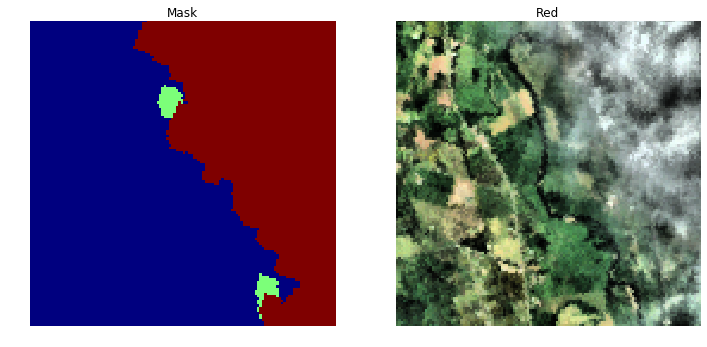

In [19]:
nth = 1

fig = plt.figure(figsize=(12,6))

s1 = fig.add_subplot(1,2,1)
s1.axis('off')
s1.set_title("Mask")
s1.imshow(masks[nth].data, interpolation='nearest')

s2 = fig.add_subplot(1,2,2)
s2.axis('off')
s2.set_title("Red")

rgb = np.dstack([sr_b3[nth].data, sr_b2[nth].data, sr_b1[nth].data])
norm = mc.Normalize(0.0, 1.0, clip=True)
equalized = ex.equalize_adapthist(norm(rgb), clip_limit=0.05)
s2.imshow(equalized, interpolation='nearest')

In [18]:
masks[1].source, sr_b1[nth].source

('LE70460272001143EDC00', 'LE70460272001127EDC00')